# Classification and Regression Trees, and Bagging
https://harvard-iacs.github.io/2020-CS109A/lectures/lecture22/notebook/

**Classification criteria** 
1. Classification error - misclassification rate --- (1 - max class proportion)
2. Gini index - based on the purity of the split --- (1 - sum of class proportions)
3. Entropy - Quantifies the discrimination of the split. Higher entropy means all values equally possible and hence values less predictable, lower entropy means distribution is more defined with peaks and valleys and hence more predictable.

**Stopping and pruning** <br>

Fit a detailed tree on the training set and prune the tree based on the error on the validation set. Cost complexity pruning is one method where cost $C = Error(T) + \alpha \lvert{T}\rvert$, where, T is nummber of leaves in tree and $\alpha$ is model complexity parameter. This means that as T increases, error decreases with extra cost. Find the min cost for various values of $\alpha$ using cross validation.


<img src="./images/tree_error.png" style="width: 800px;" >

In [441]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

## Classification Trees

In [2]:
# Read the data
elect_train = pd.read_csv("data/county_election_train.csv")
elect_test = pd.read_csv("data/county_election_test.csv")
elect_train.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,trump,clinton,votergap
0,Alabama,1001,Autauga County,50756,2.842,22.733,51.475,5.2,54366,13.8,21.9,28.6,34.1,91.8,186.5,73.436,23.957,49.479
1,Alabama,1003,Baldwin County,179878,4.550,12.934,51.261,5.5,49626,11.0,28.6,22.3,27.4,114.6,229.4,77.351,19.565,57.786
2,Alabama,1007,Bibb County,21587,2.409,23.930,46.110,6.6,39546,22.1,10.2,33.9,40.3,36.8,230.3,76.966,21.422,55.544
3,Alabama,1009,Blount County,58345,8.954,4.229,50.592,5.4,45567,21.9,12.3,28.0,34.6,88.9,205.3,89.852,8.470,81.382
4,Alabama,1011,Bullock County,10985,7.526,72.831,45.241,7.8,26580,34.5,14.1,31.7,43.0,17.5,211.2,24.229,75.090,-50.862


In [10]:
# create response variable for Trump win or lose
y_train = 1*(elect_train['trump'] > elect_train['clinton'])
y_test = 1*(elect_test['trump'] > elect_test['clinton'])

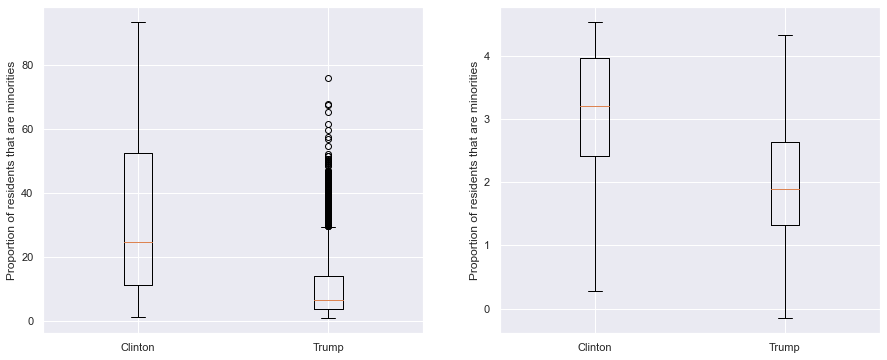

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[15,6])

ax1.boxplot([elect_train.loc[y_train==0]['minority'],
             elect_train.loc[y_train==1]['minority']],
             labels=("Clinton","Trump"))
ax1.set_ylabel("Proportion of residents that are minorities")

ax2.boxplot([np.log(elect_train.loc[y_train==0]['minority']),
             np.log(elect_train.loc[y_train==1]['minority'])],
             labels=("Clinton","Trump"))
ax2.set_ylabel("Proportion of residents that are minorities")
plt.show()

## Ways to stop the tree
```max_depth```
```min_samples_split```
```min_samples_leaf```

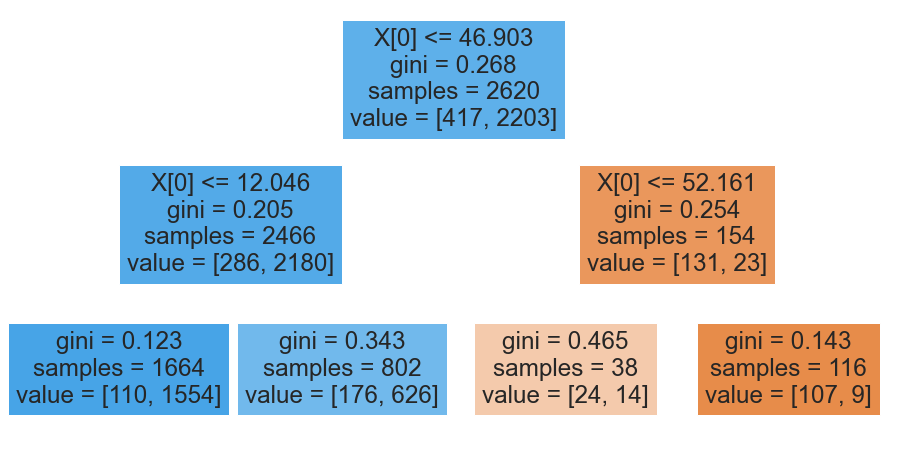

In [60]:
plt.figure(figsize=(16,8))
dtree = DecisionTreeClassifier(max_depth = 2)
dtree.fit(elect_train[['minority']],y_train)
tree.plot_tree(dtree, filled=True)
plt.show()

## Fit using two predictors - minority and bachelor degree

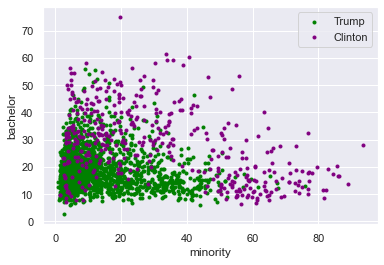

In [52]:
plt.scatter(elect_train['minority'][y_train==1], elect_train['bachelor'][y_train==1],
            marker=".", color="green", label="Trump")

plt.scatter(elect_train['minority'][y_train==0], elect_train['bachelor'][y_train==0],
            marker=".", color="purple",label="Clinton")

plt.xlabel("minority")
plt.ylabel("bachelor")
plt.legend()
plt.show()

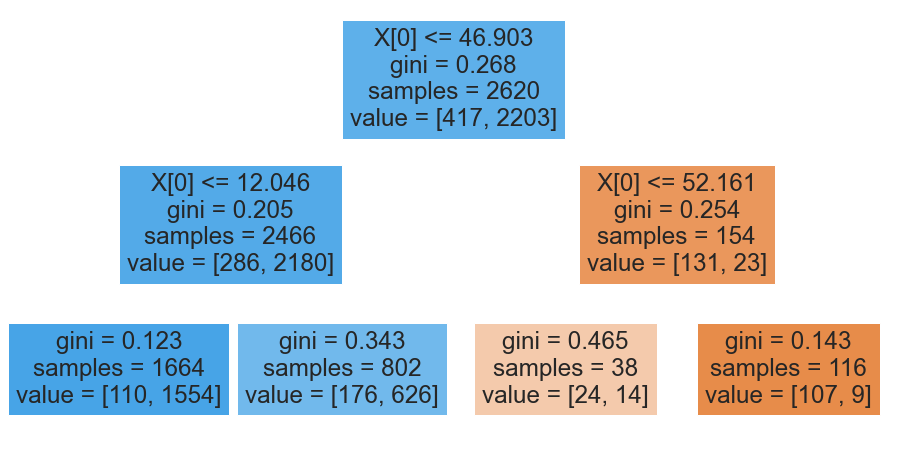

In [61]:
plt.figure(figsize=(16,8))
dtree2 = DecisionTreeClassifier(max_depth = 3)
dtree2.fit(elect_train[['minority', 'bachelor']],y_train)
tree.plot_tree(dtree, filled=True)
plt.show()

## Fit using 8 predictors

In [120]:
X_train = elect_train[['minority', 'density','hispanic','obesity','female','income','bachelor','inactivity']]
X_test = elect_test[['minority', 'density','hispanic','obesity','female','income','bachelor','inactivity']]

dtree15 = DecisionTreeClassifier(max_depth = 15)
dtree15.fit(X_train, y_train);

ypred_train = dtree15.predict(X_train)
ypred_test = dtree15.predict(X_test)


In [121]:
dtree15_train_acc = sum(ypred_train == y_train)/y_train.shape[0]
dtree15_test_acc = sum(ypred_test == y_test)/y_test.shape[0]

print("Train accuracy =", float('%.4g' % dtree15_train_acc),
      "\n Test accuracy =",float('%.4g' % dtree15_test_acc))

Train accuracy = 0.9996 
 Test accuracy = 0.8984


## Feature Importance
- The ```feature_importances_``` the measures the total improvement (reduction) of the cost/loss/criterion every time that feature defines a split. Note: the default is ```criterion ='gini```.

- A "predicted probability plot" to get a very rough idea as to what the model is saying about how the chances of a county voting for Trump in 2016 were related to minority

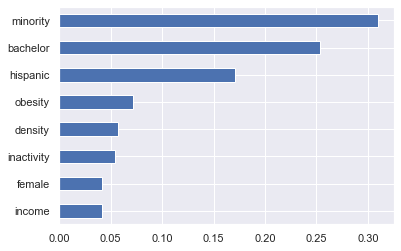

In [122]:
pd.Series(dtree15.feature_importances_, index=list(X_train)).sort_values().plot(kind="barh");

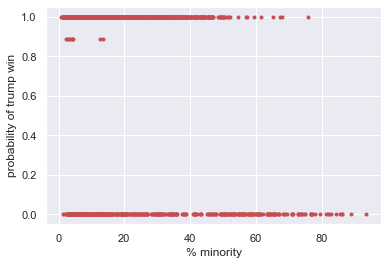

In [129]:
# predicted probability
phat15 = dtree15.predict_proba(X_train)[:,1]

plt.plot(elect_train['minority'], phat15, '.', color = 'r')
plt.xlabel('% minority')
plt.ylabel('probability of trump win');

# Shows that for minority % > 55, probability of trump winning is almost zero.

## 5-fold cross validation
For each value of depth, cross validation splits the training data into n-folds, fits the best tree using the (n-1) folds and calcualtes the accuracy on the nth fold. Using this we can get the best depth or other criteria for the tree.


In [132]:
np.random.seed(109)

depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []
cv_scores = []

for depth in depths:
    dtree = DecisionTreeClassifier(max_depth = depth)
    
    # fit the model and then get the score for the whole train set
    train_scores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    
    # use the fitted model to perform cross validation, get scores for each of the five folds
    scores = cross_val_score(estimator = dtree, X = X_train, y = y_train, cv = 5)
    
    # store the mean and std for the scores
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

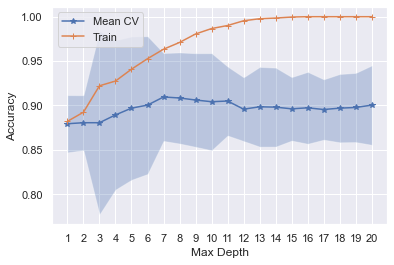

In [133]:
# plot means and shade the 2*SD interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

## Regression Tree with bagging
- https://harvard-iacs.github.io/2020-CS109A/lectures/lecture23/notebook-2/
- Bagging = **B**ootstrap **Agg**regation
- Bootstrap - generate multiple samples with replacement from the training data
- Aggregation - average the output of all models with the bootstrap samples
- Cross validate using the Out of Bag Error (OOB)
- Variable Importance
- Improve bagging output when tree are highly correlated

In [581]:
df = pd.read_csv("./data/airquality.csv", index_col = 0)
df.head()
df = df[df.Ozone.notna()]  # drop NA alues

# set x an y values
x = df[['Ozone']].values
y = df['Temp']

# split train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=102)


In [584]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Fit a decision tree with depth 3
#dtree3 = DecisionTreeClassifier(max_depth = 2)
dtree3 = DecisionTreeRegressor(max_depth = 2)
dtree3.fit(x_train, y_train)

# Bagging Regressor model
num_bootstraps = 30   # number of times to run the tree model with the bootstrapped samples
bagreg = BaggingRegressor(base_estimator = dtree3,
                          n_estimators = num_bootstraps, 
                          random_state = 22)

# Fit and predict the model
bagreg.fit(x_train, y_train)


BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=2),
                 n_estimators=30, random_state=22)

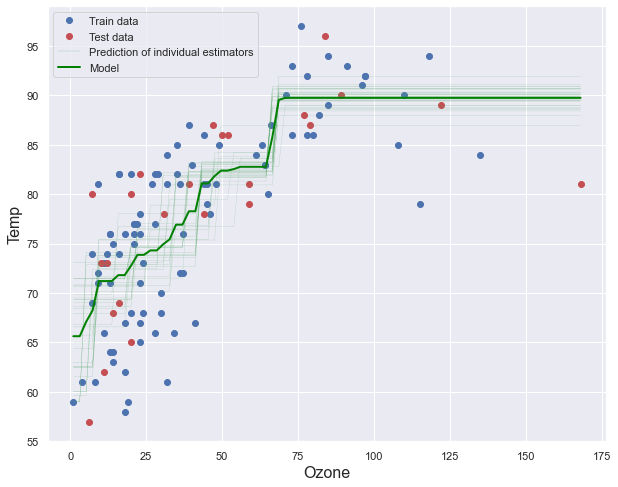

In [585]:
plt.figure(figsize=(10,8))

# get a set os 80 values between x.min and x.max
xrange = np.linspace(x.min(),x.max(),80).reshape(-1,1)

plt.plot(x_train, y_train, 'o', label = 'Train data')
plt.plot(x_test, y_test, 'o', color = 'r', label = 'Test data')

# do predictions for bootstap values from 1 to n_estimators
for i in bagreg.estimators_:
    y_pred1 = i.predict(xrange)  # predict output for each of the 30 models
    plt.plot(xrange, y_pred1, lw = 0.2, alpha = 0.6, color = 'g')

# plotting y_pred1 just for the label, else legend has 30 items
plt.plot(xrange, y_pred1, lw = 0.2, color = 'g', label = 'Prediction of individual estimators')

# predict based on the aggregate model
y_pred = bagreg.predict(xrange)
plt.plot(xrange, y_pred, lw = 2, color = 'green', label = 'Model')
    
plt.xlabel('Ozone', fontsize = 16)
plt.ylabel('Temp', fontsize = 16)
plt.legend();

In [586]:
# This consists of 30 models that were run based on the n_estimators
# BaggingRegressor then aggregate the outputs from each of the models
# The plot above shows the output for each of the models in transparent lines 
# and fthe aggregated output in solid line
bagreg.estimators_

[DecisionTreeRegressor(max_depth=2, random_state=1929108492),
 DecisionTreeRegressor(max_depth=2, random_state=1564504698),
 DecisionTreeRegressor(max_depth=2, random_state=986264995),
 DecisionTreeRegressor(max_depth=2, random_state=406464487),
 DecisionTreeRegressor(max_depth=2, random_state=1667561438),
 DecisionTreeRegressor(max_depth=2, random_state=1785127802),
 DecisionTreeRegressor(max_depth=2, random_state=369401809),
 DecisionTreeRegressor(max_depth=2, random_state=810079931),
 DecisionTreeRegressor(max_depth=2, random_state=254568165),
 DecisionTreeRegressor(max_depth=2, random_state=2013599607),
 DecisionTreeRegressor(max_depth=2, random_state=1956958063),
 DecisionTreeRegressor(max_depth=2, random_state=1154778033),
 DecisionTreeRegressor(max_depth=2, random_state=1002818747),
 DecisionTreeRegressor(max_depth=2, random_state=695340064),
 DecisionTreeRegressor(max_depth=2, random_state=1234105465),
 DecisionTreeRegressor(max_depth=2, random_state=530161509),
 DecisionTreeRe

In [588]:
# Check the MSE of model
y_pred = bagreg.predict(x_test)
print("The test MSE of the model is",round(mean_squared_error(y_test,y_pred),2))

# MSE of individual prediction of individual models
y_pred_ind = bagreg.estimators_[0].predict(x_test)
print("The test MSE of one estimator in the model is", round(mean_squared_error(y_test,y_pred_ind),2))

y_pred_ind = bagreg.estimators_[25].predict(x_test)
print("The test MSE of one estimator in the model is", round(mean_squared_error(y_test,y_pred_ind),2))

The test MSE of the model is 32.58
The test MSE of one estimator in the model is 33.0
The test MSE of one estimator in the model is 37.43


## Classification with Bagging
- https://harvard-iacs.github.io/2020-CS109A/lectures/lecture23/notebook/

In [255]:
# Read the file 'agriland.csv' and take a quick look at your data
df = pd.read_csv('./data/agriland.csv')
df.head()

,latitude,longitude,land_type
0,-0.071860,-1.297410,1.0
1,-0.179482,-0.874892,1.0
2,-1.217428,-1.352105,0.0
3,1.143306,-0.894172,1.0
4,-3.033199,0.818646,0.0


In [281]:
# set x an y values
x = df[['latitude', 'longitude']].values
y = df['land_type']

# split train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=102)

# build tree model
max_depth = 3
clf = DecisionTreeClassifier(max_depth = max_depth, random_state=44)
clf.fit(x_train, y_train)

# predict and calc accuracy
prediction = clf.predict(x_test)
single_acc = sum(prediction == y_test)/y_test.shape[0]
print(f'Single tree Accuracy is {single_acc*100}%')

Single tree Accuracy is 82.5%


In [284]:
from sklearn.ensemble import BaggingClassifier

# Bagging ClassificationRegressor model
num_bootstraps = 30   # number of times to run the tree model with the bootstrapped samples
bagclass = BaggingClassifier(base_estimator = clf, n_estimators = num_bootstraps, random_state = 202)
# Fit and predict model
bagclass.fit(x_train, y_train)
y_pred = bagclass.predict(x_test)

# accuracy
bagclass_acc = sum(y_pred == y_test)/y_test.shape[0]
print(f'Single tree Accuracy is {bagclass_acc*100}%')
                

Single tree Accuracy is 87.5%


In [302]:
# Get accuracy as function of number of bootstrap
acc = []
n = np.linspace(1,250,250).astype(int)  # 250 values of bootstrap

for i in range(1,200):
    bagclass = BaggingClassifier(base_estimator = clf, n_estimators = i, random_state = 202)
    bagclass.fit(x_train, y_train)
    y_pred = bagclass.predict(x_test)
    acc.append(sum(y_pred == y_test)/y_test.shape[0])
    
    

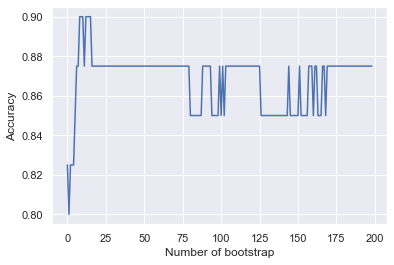

In [362]:
plt.plot(acc)
plt.xlabel('Number of bootstrap')
plt.ylabel('Accuracy');

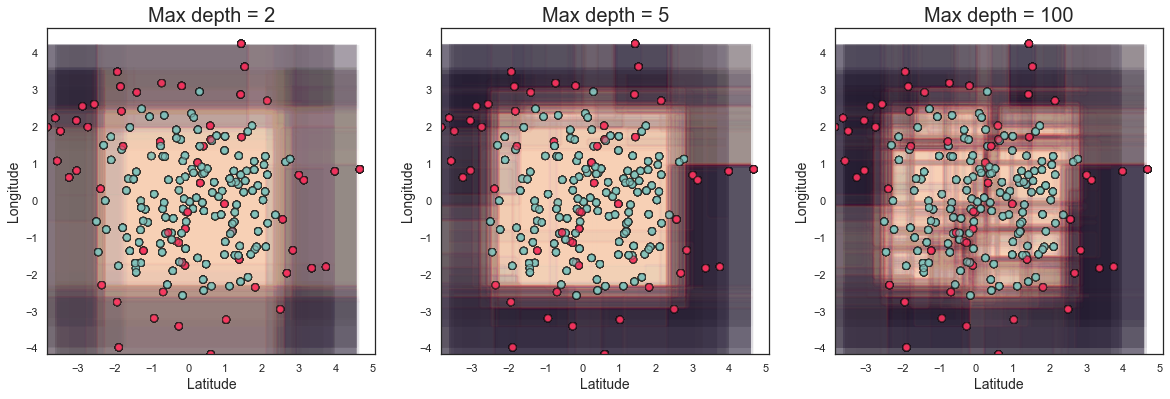

In [364]:
from matplotlib.colors import ListedColormap
sns.set(style = 'white')

cmap_light = ListedColormap(['#FFF4E5','#D2E3EF'])
cmap_bold = ListedColormap(['#F7345E','#80C3BD'])

# We will make plots for three different values of `max_depth`

fig,axes = plt.subplots(1,3,figsize=(20,6))

# Make a list of three max_depths to investigate
max_depth = [2,5,100]

# Fix the number of bootstraps

numboot = 100

for index,ax in enumerate(axes):

    for i in range(numboot):
        df_new = df.sample(frac=1,replace=True)
        y = df_new.land_type.values
        X = df_new[['latitude', 'longitude']].values
        dtree = DecisionTreeClassifier(max_depth=max_depth[index])
        dtree.fit(X, y)
        ax.scatter(X[:, 0], X[:, 1], c=y-1, s=50,alpha=0.5,edgecolor="k", cmap=cmap_bold) 
        plot_step_x1= 0.1
        plot_step_x2= 0.1
        x1min, x1max= X[:,0].min(), X[:,0].max()
        x2min, x2max= X[:,1].min(), X[:,1].max()
        x1, x2 = np.meshgrid(np.arange(x1min, x1max, plot_step_x1), np.arange(x2min, x2max, plot_step_x2) )
        # Re-cast every coordinate in the meshgrid as a 2D point
        Xplot= np.c_[x1.ravel(), x2.ravel()]

        # Predict the class
        y = dtree.predict( Xplot )
        y= y.reshape( x1.shape )
        cs = ax.contourf(x1, x2, y, alpha=0.02)
        
        
    ax.set_xlabel('Latitude',fontsize=14)
    ax.set_ylabel('Longitude',fontsize=14)
    ax.set_title(f'Max depth = {max_depth[index]}',fontsize=20)

## Random Forest
https://harvard-iacs.github.io/2020-CS109A/lectures/lecture25/notebook/

In [434]:
df = pd.read_csv("./data/heart.csv", index_col = 0)
print(df.shape)
df.head()

(303, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [435]:
# drop the rows with NA values
df = df.dropna(axis = 'rows')
np.sum(df.isna())

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

In [484]:
# convert AHD column to 1s and 0s to make it y
y = df.AHD.map(lambda x:0 if x == 'No' else 1).values

# This converts columns with categorical variables into 1s and 0s
x = pd.get_dummies(df.iloc[:,:-1]).values

x_colnames = pd.get_dummies(df.iloc[:,:-1]).columns

### Single Tree

In [492]:
from sklearn import tree

# Single Tree
max_depth = 5
tree = DecisionTreeClassifier(max_depth = max_depth, random_state=44)
tree.fit(x, y);

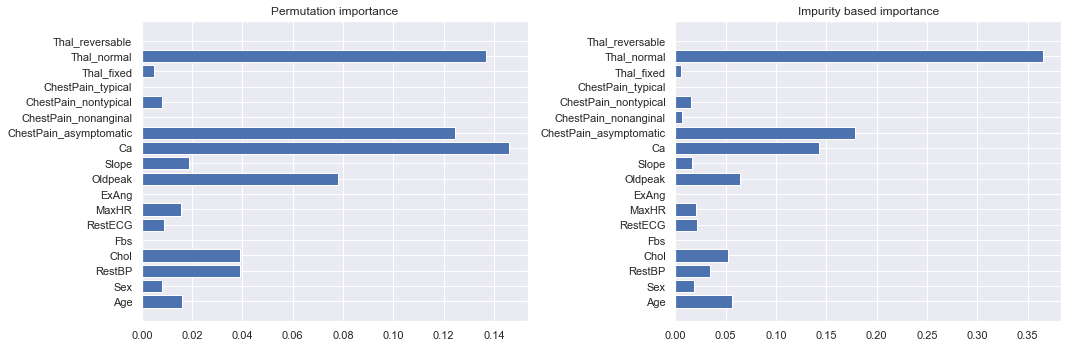

In [493]:
from sklearn.inspection import permutation_importance

# Feature Importance using permutation
tree_imp_permute = permutation_importance(tree, x, y).importances_mean

# Feature importance using MDI
tree_imp_mdi = tree.feature_importances_

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.barh(x_colnames, tree_imp_permute)
plt.title('Permutation importance')

plt.subplot(1,2,2)
plt.barh(x_colnames, tree_imp_mdi)
plt.title('Impurity based importance')

plt.tight_layout()


### Random Forest
It similar to bagging where you have many trees (n_estimators) that are fit on bootstrapped samples but different in that only a subset of random predictors is used to fit the tree. This resolves the problem of highly correlated trees in bagging due to a few strong predictors.

**Tuning Random Forest**
- Number of predictors - ```max_features``` {“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    - $\sqrt{N}$ for classification
    - $N/3$ for regression
- Total number of trees in the forest: ```n_estimators```, default=100
- Complexity of each tree: stop when a leaf has <= ```min_samples_leaf``` or when we reach a certain ```max_depth```
- Use Out of Bag (OOB) samples for validation and CV

**Variable Importance**
1. Mean Decrease in Impurity (MDI) - decrease in RSS (regression) or Gini index (classification)
2. Permutation Importance - Decrease in accuracy when randomly removing a predictor in OOB accuracy
3. One step further (SHAP values, LIME)

**Other issues**
- Imbalanced dataset 
    - Use F1 score rather than accuracy... $F1 = \frac {2*Recall*Precision}{Recall + Precision}$
    - ```class_weight```, SMOTE - library that does upsampling by interpolation
- Categorical data - ```OneHotEncoder``` or ```df.get_dummies``` to convert into separate 1/0 columns for categories
- Missing data - use skleanr's surrogate splits, where another predictor similar to the missing one is used in the split.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier

In [504]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10,  # number of trees
                            max_depth = max_depth,
                            #min_samples_split = 20, 
                            #min_samples_leaf = 10, 
                            #bootstrap=True, 
                            #oob_score=False,
                            )
rf.fit(x,y);

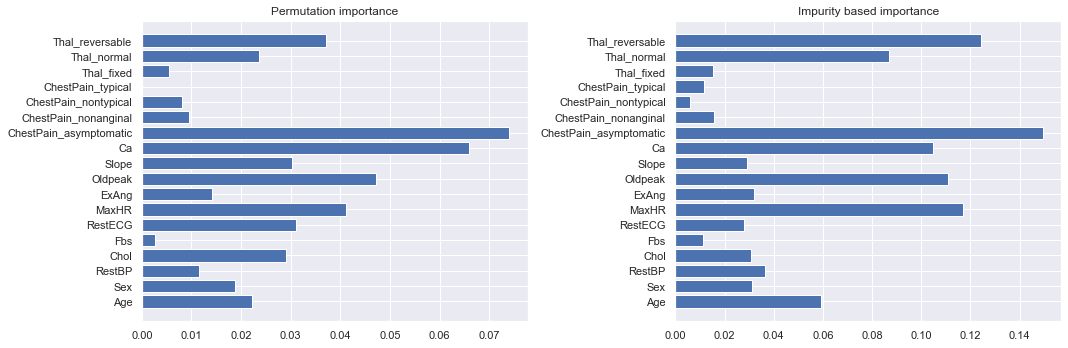

In [505]:
# Feature Importance using permutation
rf_imp_permute = permutation_importance(rf, x, y).importances_mean

# Feature importance using MDI
rf_imp_mdi = rf.feature_importances_

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.barh(x_colnames, rf_imp_permute)
plt.title('Permutation importance')

plt.subplot(1,2,2)
plt.barh(x_colnames, rf_imp_mdi)
plt.title('Impurity based importance')

plt.tight_layout()

### Random Forest - class weights and SMOTE classification
https://harvard-iacs.github.io/2020-CS109A/lectures/lecture25/notebook-2/

## Boosting
- Regression - Fit a simple model, calculate residuals, fit residuals and add to simple model, and so on...
- Classification - Adaboost

https://github.com/rohitash-chandra/dataminingMATH5836/blob/master/Week8/Week%208_%20Ensemble%20learning.pdf
http://www.inf.fu-berlin.de/inst/ag-ki/adaboost4.pdf

<img src="./images/boosting_algo.png" style="width: 800px;" >

### Tutorial on sorting two arrays based on one of them

In [572]:
x = [1,2,3,4,5]
y = [10,9,8,7,6]

print("combine into a list:     ", list(zip(x, y)))
    
print("sort list based on y:    ", list(sorted(zip(y, x))))

print("separate into two arrays:", list(zip(*sorted(zip(y, x)))))

# extract the x and y
x, y = list(zip(*sorted(zip(y, x))))

print("x : ", x)
print("y : ", y)


combine into a list:      [(1, 10), (2, 9), (3, 8), (4, 7), (5, 6)]
sort list based on y:     [(6, 5), (7, 4), (8, 3), (9, 2), (10, 1)]
separate into two arrays: [(6, 7, 8, 9, 10), (5, 4, 3, 2, 1)]
x :  (6, 7, 8, 9, 10)
y :  (5, 4, 3, 2, 1)


### Gradient boost by hand on sin(x)

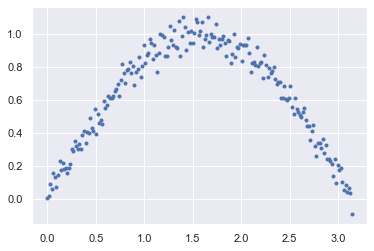

In [726]:
x = np.linspace(0,3.14,200)
y = np.sin(x) + np.random.normal(loc = 0, scale = 0.05, size = x.shape[0] )

plt.plot(x, y, '.');

In [765]:
x = x.reshape(-1,1)

# Fit a single decision tree
max_depth = 3
tree1 = DecisionTreeRegressor(max_depth = max_depth)
tree1.fit(x, y)
y1 = tree1.predict(x)
ypred1 = y1

# calculate residuals
resid1 = y - y1

# Fit tree on residuals and predict
tree2 = DecisionTreeRegressor(max_depth = max_depth)
tree2.fit(x, resid1)
y2 = tree2.predict(x)

ypred2 = y1 + y2

# calculate residuals
resid2 = y - y1 - y2

# Fit tree on residual and predict
tree3 = DecisionTreeRegressor(max_depth = max_depth)
tree3.fit(x, resid2)
y3 = tree2.predict(x)

ypred3 = y1 + y2 + y3


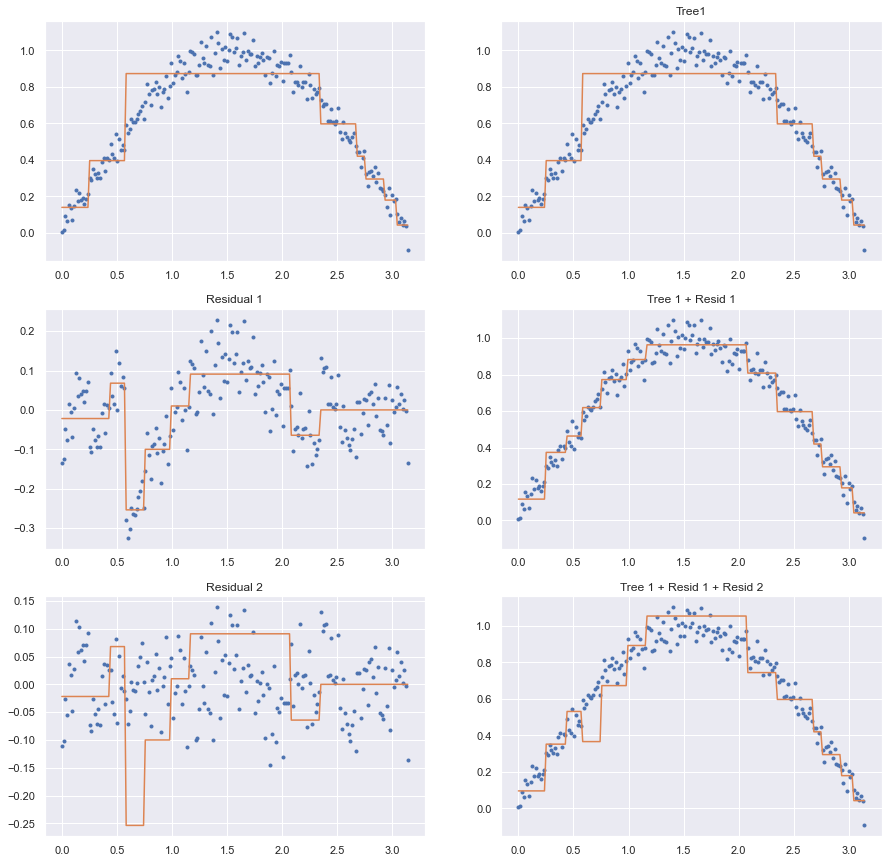

In [767]:
plt.figure(figsize = (15,15))

plt.subplot(3,2,1)
plt.plot(x, y, '.', label = 'Training')
plt.plot(x, y1)

plt.subplot(3,2,2)
plt.plot(x, y, '.', label = 'Training')
plt.plot(x, ypred1)
plt.title('Tree1')

plt.subplot(3,2,3)
plt.plot(x, resid1, '.')
plt.plot(x, y2)
plt.title('Residual 1')

plt.subplot(3,2,4)
plt.plot(x, y, '.', label = 'Training')
plt.plot(x, ypred2)
plt.title('Tree 1 + Resid 1')

plt.subplot(3,2,5)
plt.plot(x, resid2, '.')
plt.plot(x, y3)
plt.title('Residual 2')

plt.subplot(3,2,6)
plt.plot(x, y, '.', label = 'Training')
plt.plot(x, ypred3)
plt.title('Tree 1 + Resid 1 + Resid 2');



### Gradient Boosting using sklearn

https://harvard-iacs.github.io/2020-CS109A/lectures/lecture26/notebook-2/

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingRegressor

In [662]:
# split train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=102)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# initialize model --- defaul loss function is squared error
boosted_reg = GradientBoostingRegressor(learning_rate = 0.1,
                                        n_estimators = 5000,
                                        random_state = 102)
# fit model and predict
boosted_reg.fit(x_train, y_train)
ypred_boosting = boosted_reg.predict(x_test);

# calculate MSE
mse_boosting = mean_squared_error(ypred, y_test)
print("The MSE of the Boosting model is", mse_boosting)


The MSE of the Boosting model is 55.98379629629602


In [699]:
# Fit bagging regression

bagtree = DecisionTreeRegressor(max_depth = 100)
bagtree.fit(x_train, y_train)

bagreg = BaggingRegressor(base_estimator = bagtree,
                          n_estimators = 30,
                          max_samples = 0.8,
                          random_state = 3)

# Fit and predict the model
bagreg.fit(x_train, y_train)
ypred_bagreg = bagreg.predict(x_test);

# calculate MSE
mse_bagging = mean_squared_error(ypred_bagreg, y_test)
print("The MSE of the Bagging model is", mse_bagging)

The MSE of the Bagging model is 55.01029065728144


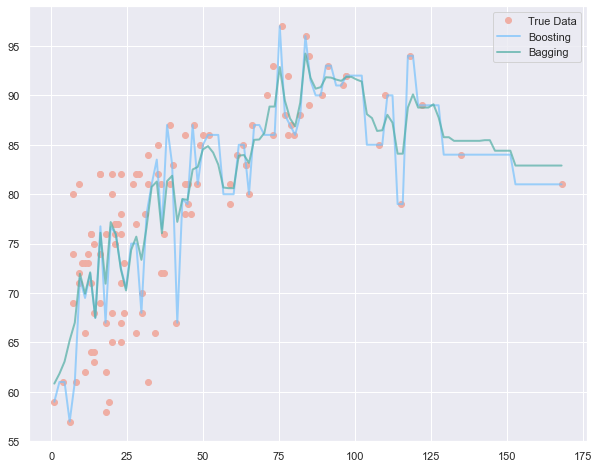

In [700]:
# PLot and compare boosting vs bagging for regression
plt.figure(figsize=(10,8))

xrange = np.linspace(x.min(),x.max(),100).reshape(-1,1)
y_pred_boost = boosted_reg.predict(xrange)
y_pred_bag = bagreg.predict(xrange)


plt.plot(x, y, 'o', color='#EFAEA4', markersize=6, label="True Data")
plt.plot(xrange, y_pred_boost, alpha=0.7, linewidth=2, color='#77c2fc', label='Boosting')
plt.plot(xrange,y_pred_bag,alpha=0.7,linewidth=2,color='#50AEA4', label='Bagging');

plt.legend();

## Adaboost for classification

https://harvard-iacs.github.io/2020-CS109A/lectures/lecture26/notebook/

In [777]:
from sklearn.ensemble import AdaBoostClassifier
from helper import plot_decision_boundary

# Read the dataset as a pandas dataframe
df = pd.read_csv("./data/boostingclassifier.csv")

# Read the columns latitude and longitude as the predictor variables
X = df[['latitude','longitude']].values

# Landtype is the response variable
y = df['landtype'].values

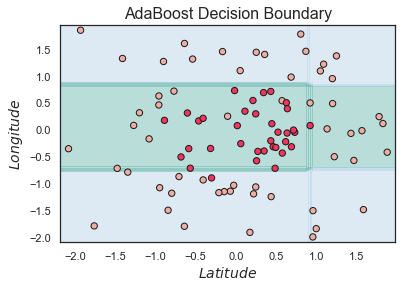

In [785]:
# Use sklearn's AdaBoostClassifier to take a look at the final decision boundary 

# Initialise the model with Decision Tree classifier as the base model same as above
# Use SAMME as the algorithm and 6 estimators with learning rate as 1
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=6, learning_rate=1)

# Fit on the entire data
boost.fit(X,y)

# Call the plot_decision_boundary function to plot the decision boundary of the model 
plot_decision_boundary(boost, X,y, N = 50)

plt.title('AdaBoost Decision Boundary', fontsize=16)
plt.show()